In [1]:
from scw_compare import get_era5_lsm
from percent_mean_change import transform_from_latlon
import matplotlib.pyplot as plt
import geopandas
import pandas as pd
from rasterio import features
from affine import Affine
import glob
import xarray as xr
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import genextreme
from tqdm import tqdm
import netCDF4 as nc
from ari import drop_duplicates
from scw_compare import rasterize

In [2]:
def load(y1, y2, djf=False, annmax=True):
    '''
        Load ARI-relevant data for BARRA and ERA5, obtained through ECDF and EV analysis in ari.py. Option to load just from 
        Summer data. Option to load in CDF data created using the annual maxima
    '''
    
    path = "/g/data/eg3/ab4502/gev/"
    if annmax:
        annmaxstr="_annmax"
    else:
        annmaxstr=""
    if djf:
        barra_gev = xr.open_dataset(path+"barra_gev_djf_"+str(y1)+"_"+str(y2)+".nc")
        barra_cdf = xr.open_dataset(path+"barra_cdf_djf_"+str(y1)+"_"+str(y2)+annmaxstr+".nc")
        barra_cdf_nrm = [ pd.read_csv(path+"barra_cdf_djf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]
        barra_max = xr.open_dataset(path+"barra_cdf_djf_"+str(y1)+"_"+str(y2)+".nc")
        barra_sy_gev = xr.open_dataset(path+"barra_sy_gev_djf_"+str(y1)+"_"+str(y2)+".nc")
        barra_sy_cdf = xr.open_dataset(path+"barra_sy_cdf_djf_"+str(y1)+"_"+str(y2)+".nc")
        barra_sy_max = xr.open_dataset(path+"barra_sy_cdf_djf_"+str(y1)+"_"+str(y2)+".nc")
        barra_sy_cdf_nrm = [ pd.read_csv(path+"barra_sy_cdf_djf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]
        barpa_gev = xr.open_dataset(path+"barpa_erai_gev_djf_"+str(y1)+"_2015.nc")
        barpa_cdf = xr.open_dataset(path+"barpa_erai_cdf_djf_"+str(y1)+"_2015"+annmaxstr+".nc")
        barpa_cdf_nrm = [ pd.read_csv(path+"barpa_erai_cdf_djf_"+str(y1)+"_2015_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]
        barpa_max = xr.open_dataset(path+"barpa_erai_cdf_djf_"+str(y1)+"_2015.nc")
        barpa_access_gev = xr.open_dataset(path+"barpa_access_gev_djf_"+str(y1)+"_"+str(y2)+".nc")
        barpa_access_cdf = xr.open_dataset(path+"barpa_access_cdf_djf_"+str(y1)+"_"+str(y2)+annmaxstr+".nc")
        barpa_access_cdf_nrm = [ pd.read_csv(path+"barpa_access_cdf_djf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]
        barpa_access_max = xr.open_dataset(path+"barpa_access_cdf_djf_"+str(y1)+"_"+str(y2)+".nc")
    else:
        barra_gev = xr.open_dataset(path+"barra_gev_"+str(y1)+"_"+str(y2)+".nc")
        barra_cdf = xr.open_dataset(path+"barra_cdf_"+str(y1)+"_"+str(y2)+annmaxstr+".nc")
        barra_cdf_nrm = [ pd.read_csv(path+"barra_cdf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]
        barra_max = xr.open_dataset(path+"barra_cdf_"+str(y1)+"_"+str(y2)+".nc")
        barra_sy_gev = xr.open_dataset(path+"barra_sy_gev_"+str(y1)+"_"+str(y2)+".nc")
        barra_sy_cdf = xr.open_dataset(path+"barra_sy_cdf_"+str(y1)+"_"+str(y2)+".nc")
        barra_sy_cdf_nrm = [ pd.read_csv(path+"barra_sy_cdf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]
        barpa_gev = xr.open_dataset(path+"barpa_erai_gev_"+str(y1)+"_"+str(y2)+".nc")
        barpa_cdf = xr.open_dataset(path+"barpa_erai_cdf_"+str(y1)+"_"+str(y2)+annmaxstr+".nc")
        barpa_cdf_nrm = [ pd.read_csv(path+"barpa_erai_cdf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]
        barpa_max = xr.open_dataset(path+"barpa_erai_cdf_"+str(y1)+"_"+str(y2)+".nc")
        barpa_access_gev = xr.open_dataset(path+"barpa_access_gev_"+str(y1)+"_"+str(y2)+".nc")
        barpa_access_cdf = xr.open_dataset(path+"barpa_access_cdf_"+str(y1)+"_"+str(y2)+annmaxstr+".nc")
        barpa_access_cdf_nrm = [ pd.read_csv(path+"barpa_access_cdf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]
        barpa_access_max = xr.open_dataset(path+"barpa_access_cdf_"+str(y1)+"_"+str(y2)+".nc")
        
    if djf:
        era5_gev = xr.open_dataset(path+"era5_gev_djf_"+str(y1)+"_"+str(y2)+".nc")
        era5_cdf = xr.open_dataset(path+"era5_cdf_djf_"+str(y1)+"_"+str(y2)+annmaxstr+".nc")
        era5_cdf_nrm = [ pd.read_csv(path+"era5_cdf_djf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]
        era5_max = xr.open_dataset(path+"era5_cdf_djf_"+str(y1)+"_"+str(y2)+".nc")
    else:
        era5_gev = xr.open_dataset(path+"era5_gev_"+str(y1)+"_"+str(y2)+".nc")
        era5_cdf = xr.open_dataset(path+"era5_cdf_"+str(y1)+"_"+str(y2)+annmaxstr+".nc")
        era5_cdf_nrm = [ pd.read_csv(path+"era5_cdf_"+str(y1)+"_"+str(y2)+"_nrm"+str(i)+annmaxstr+".csv") for i in np.arange(4) ]  
        era5_max = xr.open_dataset(path+"era5_cdf_"+str(y1)+"_"+str(y2)+".nc")
        
    return [barra_gev, barra_cdf, barra_cdf_nrm, barra_max, barpa_gev, barpa_cdf, barpa_cdf_nrm, 
            barpa_max, barpa_access_gev, barpa_access_cdf, barpa_access_cdf_nrm, barpa_access_max, 
            barra_sy_gev, barra_sy_cdf, barra_sy_cdf_nrm, barra_sy_max, era5_gev, era5_cdf, 
            era5_cdf_nrm, era5_max]   

def compute_lmom_gev(da, ari):
    '''
        From an xarray dataarray with variables containing shape, location and scale parameters for a GEV, return the values for a given ari
    '''
    
    n, m = da.c_lmom.shape
    out = np.zeros((n,m))
    c = da.c_lmom.values
    loc = da["loc_lmom"].values
    scale = da.scale_lmom.values
    p = 1 - (1 / ari)
    for i in tqdm(np.arange(n)):
        for j in (np.arange(m)):
                   out[i,j] = genextreme.isf(q=1-p, c=c[i,j], loc=loc[i,j], scale=scale[i,j])
                   
    return out

def compute_wei_lmom(da, ari):
    '''
        From an xarray dataarray with variables containing shape, location and scale parameters for a Weibull EV, return the values for a given ari
    '''
    
    n, m = da["cw_lmom"].shape
    out = np.zeros((n,m))
    c = da["cw_lmom"].values
    loc = da["locw_lmom"].values
    scale = da["scalew_lmom"].values
    p = 1 - (1 / ari)
    for i in tqdm(np.arange(n)):
        for j in (np.arange(m)):
                   out[i,j] = genextreme.isf(q=1-p, c=c[i,j], loc=loc[i,j], scale=scale[i,j])
                   
    return out

def compute_wei(da, ari):
    '''
        From an xarray dataarray with variables containing shape, location and scale parameters for a Weibull EV, return the values for a given ari
    '''
    
    n, m = da["cw"].shape
    out = np.zeros((n,m))
    c = da["cw"].values
    loc = da["locw"].values
    scale = da["scalew"].values
    p = 1 - (1 / ari)
    for i in tqdm(np.arange(n)):
        for j in (np.arange(m)):
                   out[i,j] = genextreme.isf(q=1-p, c=c[i,j], loc=loc[i,j], scale=scale[i,j])
                   
    return out

def compute_gev(da, ari):
    '''
        From an xarray dataarray with variables containing shape, location and scale parameters for a GEV, return the values for a given ari
    '''
    
    n, m = da.c.shape
    out = np.zeros((n,m))
    c = da.c.values
    loc = da["loc"].values
    scale = da.scale.values
    p = 1 - (1 / ari)
    for i in tqdm(np.arange(n)):
        for j in (np.arange(m)):
                   out[i,j] = genextreme.isf(q=1-p, c=c[i,j], loc=loc[i,j], scale=scale[i,j])
                   
    return out

def compute_lmom_gev_nrm(da):
    '''
        From the NRM-maximum annual time series-fitted GEV, compute the ARI
    '''
    T = (np.logspace(-1,3,1000))
    out =  [ genextreme.isf(q=1-(1-(1/T)), c=da.attrs["c_lmom_nrm"][i], loc=da.attrs["loc_lmom_nrm"][i], scale=da.attrs["scale_lmom_nrm"][i]) for i in np.arange(4) ]
    return [out, T]   

def compute_gev_nrm(da):
    '''
        From the NRM-maximum annual time series-fitted GEV, compute the ARI
    '''
    T = (np.logspace(-1,3,1000))
    out =  [ genextreme.isf(q=1-(1-(1/T)), c=da.attrs["nrm_c"][i], loc=da.attrs["nrm_loc"][i], scale=da.attrs["nrm_scale"][i]) for i in np.arange(4) ]
    return [out, T]   

def compute_lmom_wei_nrm(da):
    '''
        From the NRM-maximum annual time series-fitted GEV, compute the ARI
    '''
    T = (np.logspace(-1,3,1000))
    out =  [ genextreme.isf(q=1-(1-(1/T)), c=da.attrs["cw_lmom_nrm"][i], loc=da.attrs["locw_lmom_nrm"][i], scale=da.attrs["scalew_lmom_nrm"][i]) for i in np.arange(4) ]
    return [out, T]   

def compute_wei_nrm(da):
    '''
        From the NRM-maximum annual time series-fitted GEV, compute the ARI
    '''
    T = (np.logspace(-1,3,1000))
    out =  [ genextreme.isf(q=1-(1-(1/T)), c=da.attrs["nrm_cw"][i], loc=da.attrs["nrm_locw"][i], scale=da.attrs["nrm_scalew"][i]) for i in np.arange(4) ]
    return [out, T]   

def plot_borders(nrm_da):
    xr.plot.contour(xr.where(nrm_da["aus"]==1, 1, 0), levels=[0.5,1.5], colors="k", add_labels=False)
    [xr.plot.contour(xr.where((nrm_da==i) & (~(nrm_da["aus"].isnull())), 1, 0), levels=[0.5,1.5], colors="k", add_labels=False) for i in [0,1,2,3]]


In [3]:
#LOAD DATA FOR DJF

ari=10
cdf_ari="ari10"
djf=True
annmax=True
barra_gev, barra_cdf, barra_cdf_nrm, barra_max, barpa_gev, barpa_cdf, barpa_cdf_nrm, barpa_max,\
    barpa_access_gev, barpa_access_cdf, barpa_access_cdf_nrm, barpa_access_max,\
    barra_sy_gev, barra_sy_cdf, barra_sy_cdf_nrm, barra_sy_max, era5_gev, era5_cdf, era5_cdf_nrm, era5_max = \
        load(1990, 2018, djf)
barra_ari = compute_gev(barra_gev, ari)
barra_ari_nrm, T = compute_gev_nrm(barra_gev)
barra_lmom_ari = compute_lmom_gev(barra_gev, ari)
barra_ari_lmom_nrm, T = compute_lmom_gev_nrm(barra_gev)

barpa_ari = compute_gev(barpa_gev, ari)
barpa_ari_nrm, T = compute_gev_nrm(barpa_gev)
barpa_lmom_ari = compute_lmom_gev(barpa_gev, ari)
barpa_ari_lmom_nrm, T = compute_lmom_gev_nrm(barpa_gev)

barpa_access_ari = compute_gev(barpa_access_gev, ari)
barpa_access_ari_nrm, T = compute_gev_nrm(barpa_access_gev)
barpa_access_lmom_ari = compute_lmom_gev(barpa_access_gev, ari)
barpa_access_ari_lmom_nrm, T = compute_lmom_gev_nrm(barpa_access_gev)

era5_ari = compute_gev(era5_gev, ari)
era5_ari_nrm, T = compute_gev_nrm(era5_gev)
era5_lmom_ari = compute_lmom_gev(era5_gev, ari)
era5_ari_lmom_nrm, T = compute_lmom_gev_nrm(era5_gev)

#barra_sy_ari = compute_gev(barra_sy_gev, ari)
#barra_sy_nrm, T = compute_gev_nrm(barra_sy_gev)
#barra_sy_lmom_ari = compute_lmom_gev(barra_sy_gev, ari)
#barra_sy_lmom_nrm, T = compute_lmom_gev_nrm(barra_sy_gev)

era5_wei = compute_wei(era5_gev, ari)
era5_wei_nrm, T = compute_wei_nrm(era5_gev)
era5_lmom_wei = compute_wei_lmom(era5_gev, ari)
era5_wei_lmom_nrm, T = compute_lmom_wei_nrm(era5_gev)


100%|██████████| 139/139 [00:04<00:00, 30.48it/s]


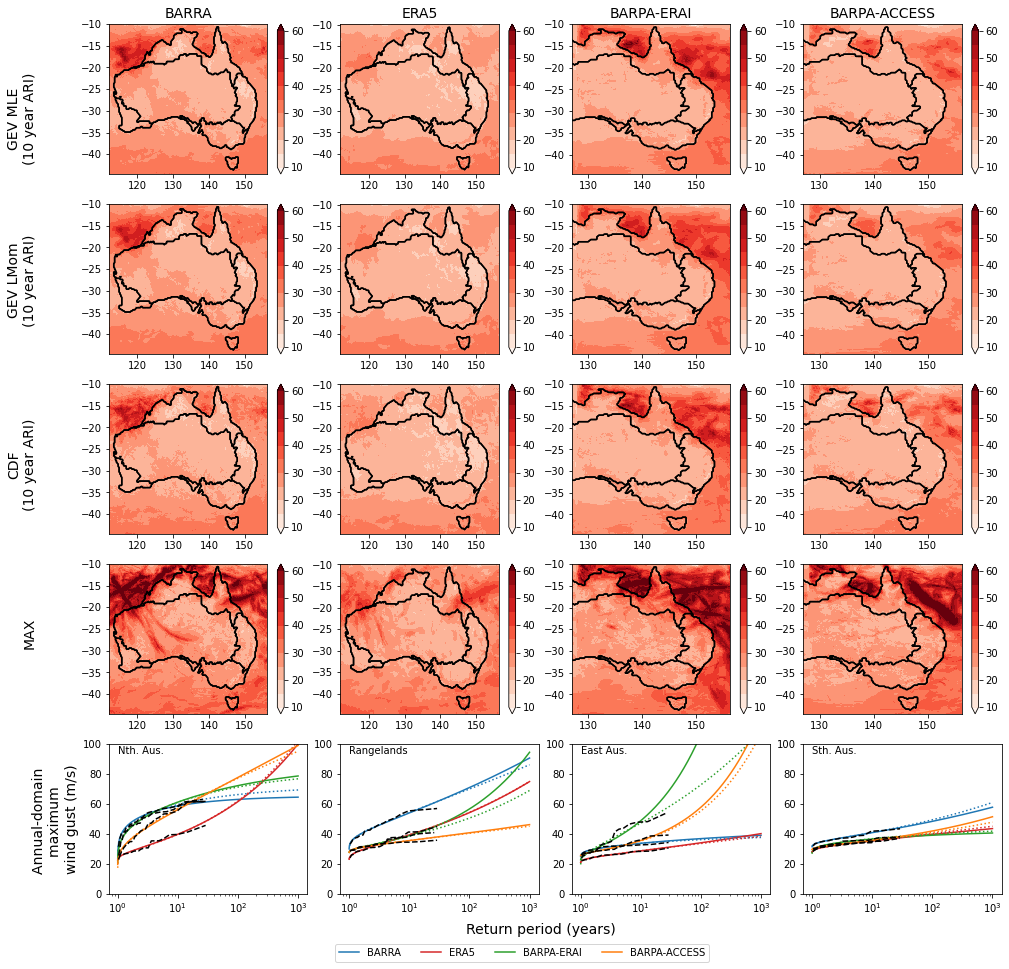

In [4]:
#PLOTTING - Aus wide

era5_range = [10,60]
barra_range = [10,60]
cmap = plt.get_cmap("Reds")
levels = 11
rows=5
cols=8

temp = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/ERA5__mean_lr36_historical_1979_2005.nc")
f = geopandas.read_file("/home/548/ab4502/NRM_super_clusters/NRM_super_clusters.shp")
f2 = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
shapes = [(shape, n) for n, shape in enumerate(f.geometry)]
nrm_da = rasterize(shapes, {"lon":temp.lon,"lat":temp.lat})
nrm_da["aus"] = rasterize([f2.loc[f2.name=="Australia"].geometry.values[0]], {"lon":temp.lon,"lat":temp.lat})

fig=plt.figure(figsize=([16,16]))

#BARRA GEV
plt.subplot2grid((rows,cols), (0,0), rowspan=1, colspan=2)
xr.DataArray(data=barra_ari, coords=(barra_gev.lat, barra_gev.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
plt.title("BARRA", size=14)

#BARRA GEV LMOM
plt.subplot2grid((rows,cols), (1,0), rowspan=1, colspan=2)
xr.DataArray(data=np.where(barra_gev.lmom_fail==0, barra_lmom_ari, np.nan), coords=(barra_gev.lat, barra_gev.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

#BARRA CDF
plt.subplot2grid((rows,cols), (2,0), rowspan=1, colspan=2)
barra_cdf[cdf_ari].plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

#BARRA MAX
plt.subplot2grid((rows,cols), (3,0), rowspan=1, colspan=2)
barra_max["max"].plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

#BARPA GEV
plt.subplot2grid((rows,cols), (0,4), rowspan=1, colspan=2)
xr.DataArray(data=barpa_ari, coords=(barpa_gev.lat, barpa_gev.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
plt.title("BARPA-ERAI", size=14)

#BARPA GEV LMOM
plt.subplot2grid((rows,cols), (1,4), rowspan=1, colspan=2)
xr.DataArray(data=np.where(barpa_gev.lmom_fail==0, barpa_lmom_ari, np.nan), coords=(barpa_gev.lat, barpa_gev.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

#BARPA CDF
plt.subplot2grid((rows,cols), (2,4), rowspan=1, colspan=2)
barpa_cdf[cdf_ari].plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

#BARPA MAX
plt.subplot2grid((rows,cols), (3,4), rowspan=1, colspan=2)
barpa_max["max"].plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

#ERA5 GEV
plt.subplot2grid((rows,cols), (0,2), rowspan=1, colspan=2)
xr.DataArray(data=era5_ari, coords=(era5_gev.lat, era5_gev.lon)).plot(vmin=era5_range[0], vmax=era5_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
plt.title("ERA5", size=14)

#ERA5 GEV LMOM
plt.subplot2grid((rows,cols), (1,2), rowspan=1, colspan=2)
xr.DataArray(data=np.where(era5_gev.lmom_fail==0, era5_lmom_ari, np.nan), coords=(era5_gev.lat, era5_gev.lon)).plot(vmin=era5_range[0], vmax=era5_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

#ERA5 CDF
plt.subplot2grid((rows,cols), (2,2), rowspan=1, colspan=2)
era5_cdf[cdf_ari].plot(vmin=era5_range[0], vmax=era5_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

#ERA5 MAX
plt.subplot2grid((rows,cols), (3,2), rowspan=1, colspan=2)
era5_max["max"].plot(vmin=era5_range[0], vmax=era5_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

#BARRA-SY GEV
#plt.subplot2grid((rows,cols), (0,6), rowspan=1, colspan=2)
#plot_borders(nrm_da)
#xr.DataArray(data=barra_sy_ari, coords=(barra_sy_gev.lat, barra_sy_gev.lon)).plot(vmin=barra_range[0], 
#        vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", xlim=[barra_gev.lon.min(), barra_gev.lon.max()], ylim=[barra_gev.lat.min(), barra_gev.lat.max()])
#plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
#plt.title("BARRA-SY", size=14)

#BARRA-SY GEV LMOM
#plt.subplot2grid((rows,cols), (1,6), rowspan=1, colspan=2)
#xr.DataArray(data=np.where(barra_sy_gev.lmom_fail==0, barra_sy_lmom_ari, np.nan), coords=(barra_sy_gev.lat, barra_sy_gev.lon)).plot(vmin=barra_range[0],
#        vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", xlim=[barra_gev.lon.min(), barra_gev.lon.max()], ylim=[barra_gev.lat.min(), barra_gev.lat.max()])
#plot_borders(nrm_da)
#plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

#BARRA-SY CDF
#plt.subplot2grid((rows,cols), (2,6), rowspan=1, colspan=2)
#barra_sy_cdf[cdf_ari].plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False, xlim=[barra_gev.lon.min(), barra_gev.lon.max()], ylim=[barra_gev.lat.min(), barra_gev.lat.max()])
#plot_borders(nrm_da)
#plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

#BARRA-SY MAX
#plt.subplot2grid((rows,cols), (3,6), rowspan=1, colspan=2)
#barra_sy_max["max"].plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False, xlim=[barra_gev.lon.min(), barra_gev.lon.max()], ylim=[barra_gev.lat.min(), barra_gev.lat.max()])
#plot_borders(nrm_da)
#plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

#BARPA-ACCESS GEV
plt.subplot2grid((rows,cols), (0,6), rowspan=1, colspan=2)
plot_borders(nrm_da)
xr.DataArray(data=barpa_access_ari, coords=(barpa_access_gev.lat, barpa_access_gev.lon)).plot(vmin=barra_range[0], 
        vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
plt.title("BARPA-ACCESS", size=14)

#BARPA-ACCESS GEV LMOM
plt.subplot2grid((rows,cols), (1,6), rowspan=1, colspan=2)
xr.DataArray(data=np.where(barpa_access_gev.lmom_fail==0, barpa_access_lmom_ari, np.nan), coords=(barpa_access_gev.lat, barpa_access_gev.lon)).plot(vmin=barra_range[0],
        vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

#BARPA-ACCESS CDF
plt.subplot2grid((rows,cols), (2,6), rowspan=1, colspan=2)
barpa_access_cdf[cdf_ari].plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

#BARRA-SY MAX
plt.subplot2grid((rows,cols), (3,6), rowspan=1, colspan=2)
barpa_access_max["max"].plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

fig.text(0.05, 0.76, "GEV MLE\n(10 year ARI)", rotation=90, size=14, ha="center")
fig.text(0.05, 0.62, "GEV LMom\n(10 year ARI)", rotation=90, size=14, ha="center")
fig.text(0.05, 0.46, "CDF\n(10 year ARI)", rotation=90, size=14, ha="center")
fig.text(0.05, 0.34, "MAX", rotation=90, size=14)
fig.text(0.5, 0.09, "Return period (years)", ha="center", size=14)

labs = ["Nth. Aus.", "Rangelands", "East Aus.", "Sth. Aus."]
for i in np.arange(4):
    plt.subplot2grid((rows,cols), (4, i*2), rowspan=2, colspan=2)
    plt.plot(T, barra_ari_nrm[i], color="tab:blue", label="BARRA")
    plt.plot(T, era5_ari_nrm[i], color="tab:red", label="ERA5")
    plt.plot(T, barra_ari_lmom_nrm[i], color="tab:blue", linestyle=":")
    plt.plot(T, barpa_ari_nrm[i], color="tab:green", label="BARPA-ERAI")
    plt.plot(T, barpa_ari_lmom_nrm[i], color="tab:green", linestyle=":")

    plt.plot(T, era5_ari_lmom_nrm[i], color="tab:red", linestyle=":")
    plt.plot(T, barpa_access_ari_nrm[i], color="tab:orange", label="BARPA-ACCESS")
    plt.plot(T, barpa_access_ari_lmom_nrm[i], color="tab:orange", linestyle=":")
    plt.plot(barpa_access_cdf_nrm[i]["T"], barpa_access_cdf_nrm[i]["wind_speed"], color="k", linestyle="--")
    plt.ylim([0,100])

    plt.plot(barra_cdf_nrm[i]["T"], barra_cdf_nrm[i]["wind_speed"], color="k", linestyle="--")
    plt.plot(era5_cdf_nrm[i]["T"], era5_cdf_nrm[i]["wind_speed"], color="k", linestyle="--")
    plt.plot(barpa_cdf_nrm[i]["T"], barpa_cdf_nrm[i]["wind_speed"], color="k", linestyle="--")

    plt.xscale("log")
    plt.xticks(ticks=[1,10,100,1000])
    plt.text(1, plt.gca().get_ylim()[1]*0.99, labs[i], va="top", fontdict={"size":10})
    if i == 0:
        plt.gca().set_ylabel("Annual-domain \nmaximum \nwind gust (m/s)",fontdict={"size":14})
plt.legend(ncol=4, bbox_to_anchor=[-0.45,-0.3])
plt.subplots_adjust(wspace=0.4)
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/ari/hist_ari10_barrra_era5_djf.png",bbox_inches="tight")

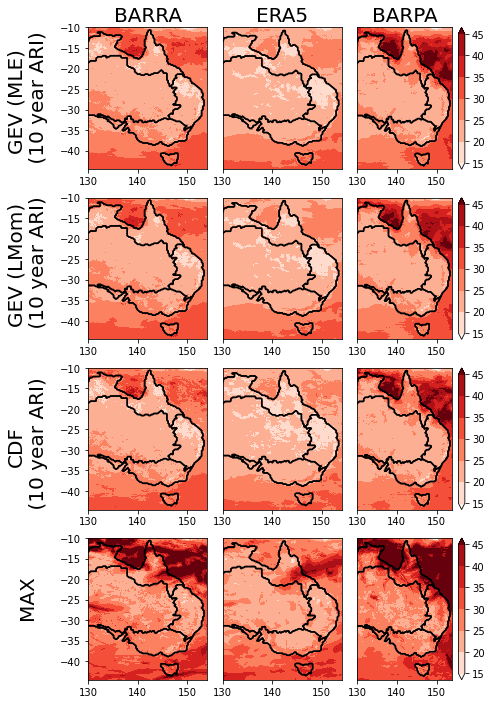

In [37]:
#PLOTTING - East Aus.

era5_range = [15,45]
barra_range = [15,45]
cmap = plt.get_cmap("Reds")
levels = 7

temp = xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/ERA5__mean_lr36_historical_1979_2005.nc")
f = geopandas.read_file("/home/548/ab4502/NRM_super_clusters/NRM_super_clusters.shp")
f2 = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
shapes = [(shape, n) for n, shape in enumerate(f.geometry)]
nrm_da = rasterize(shapes, {"lon":temp.lon,"lat":temp.lat})
nrm_da["aus"] = rasterize([f2.loc[f2.name=="Australia"].geometry.values[0]], {"lon":temp.lon,"lat":temp.lat})

fig=plt.figure(figsize=([7,12]))

plt.subplot2grid((4,6), (0,0), rowspan=1, colspan=2)
plt.title("BARRA", size=20)
xr.DataArray(data=barra_ari, coords=(barra_gev.lat, barra_gev.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False, add_colorbar=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154])

plt.subplot2grid((4,6), (1,0), rowspan=1, colspan=2)
#xr.DataArray(data=np.where(barra_gev.lmom_fail==0, barra_lmom_ari, np.nan), coords=(barra_gev.lat, barra_gev.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
xr.DataArray(data=barra_lmom_ari, coords=(barra_gev.lat, barra_gev.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False, add_colorbar=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154])

plt.subplot2grid((4,6), (2,0), rowspan=1, colspan=2)
barra_cdf[cdf_ari].plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False, add_colorbar=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154])

plt.subplot2grid((4,6), (3,0), rowspan=1, colspan=2)
barra_max["max"].plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False, add_colorbar=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154])

plt.subplot2grid((4,6), (0,2), rowspan=1, colspan=2)
plt.title("ERA5", size=20)
xr.DataArray(data=era5_ari, coords=(era5_gev.lat, era5_gev.lon)).plot(vmin=era5_range[0], vmax=era5_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False, add_colorbar=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154]); plt.yticks(ticks=[0])

plt.subplot2grid((4,6), (1,2), rowspan=1, colspan=2)
xr.DataArray(data=np.where(era5_gev.lmom_fail==0, era5_lmom_ari, np.nan), coords=(era5_gev.lat, era5_gev.lon)).plot(vmin=era5_range[0], vmax=era5_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False, add_colorbar=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154]); plt.yticks(ticks=[0])

plt.subplot2grid((4,6), (2,2), rowspan=1, colspan=2)
era5_cdf[cdf_ari].plot(vmin=era5_range[0], vmax=era5_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False, add_colorbar=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154]);plt.yticks(ticks=[0])

plt.subplot2grid((4,6), (3,2), rowspan=1, colspan=2)
era5_max["max"].plot(vmin=era5_range[0], vmax=era5_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False, add_colorbar=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154]); plt.yticks(ticks=[0])

plt.subplot2grid((4,6), (0,4), rowspan=1, colspan=2)
xr.DataArray(data=barpa_ari, coords=(barpa_gev.lat, barpa_gev.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", yticks=[0])
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154])
plt.title("BARPA", size=20)

plt.subplot2grid((4,6), (1,4), rowspan=1, colspan=2)
xr.DataArray(data=barpa_lmom_ari, coords=(barpa_gev.lat, barpa_gev.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", yticks=[0])
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154])

plt.subplot2grid((4,6), (2,4), rowspan=1, colspan=2)
barpa_cdf[cdf_ari].plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False, yticks=[0])
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154])

plt.subplot2grid((4,6), (3,4), rowspan=1, colspan=2)
barpa_max["max"].plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False, yticks=[0])
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154])


fig.text(0.01, 0.72, "GEV (MLE)\n (10 year ARI)", rotation=90, size=20, ha="center")
fig.text(0.01, 0.53, "GEV (LMom)\n (10 year ARI)", rotation=90, size=20, ha="center")
fig.text(0.01, 0.32, "CDF\n (10 year ARI)", rotation=90, size=20, ha="center")
fig.text(0.01, 0.2, "MAX", rotation=90, size=20, ha="center")


plt.subplots_adjust(wspace=0.3, left=0.13)
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/ari/hist_ari10_barrra_era5_EASTAUS_djf.png",bbox_inches="tight")

In [25]:
#LOAD DATA FOR ALL MONTHS

djf=False
barra_gev, barra_cdf, barra_cdf_nrm, barra_max, era5_gev, era5_cdf, era5_cdf_nrm, era5_max = load(1990, 2018, djf)
barra_ari = compute_gev(barra_gev, ari)
era5_ari = compute_gev(era5_gev, ari)
barra_ari_nrm, T = compute_gev_nrm(barra_gev)
era5_ari_nrm, T = compute_gev_nrm(era5_gev)
barra_lmom_ari = compute_lmom_gev(barra_gev, ari)
era5_lmom_ari = compute_lmom_gev(era5_gev, ari)
barra_ari_lmom_nrm, T = compute_lmom_gev_nrm(barra_gev)
era5_ari_lmom_nrm, T = compute_lmom_gev_nrm(era5_gev)

100%|██████████| 139/139 [00:04<00:00, 31.96it/s]


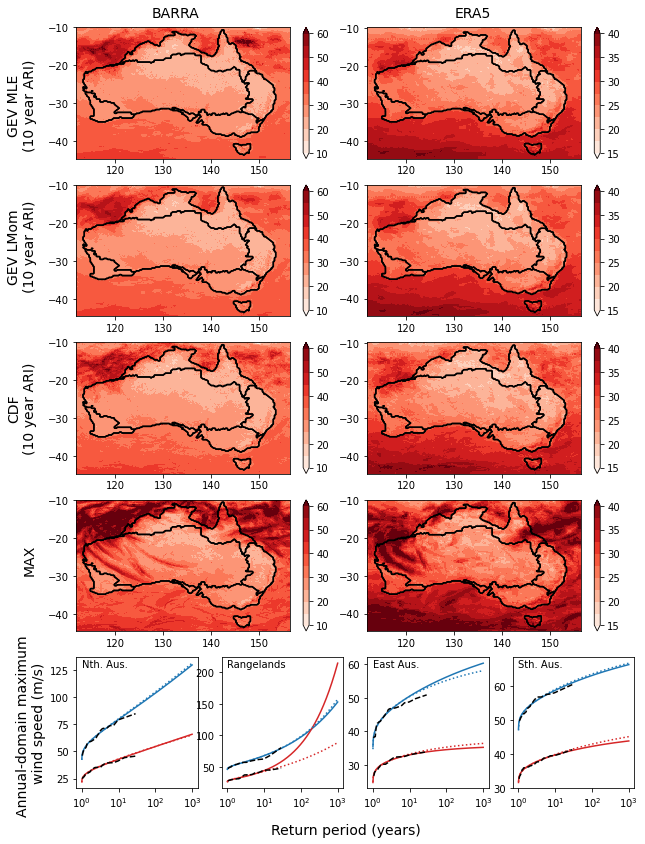

In [26]:
#PLOTTING - Aus wide

era5_range = [15,40]
barra_range = [10,60]
cmap = plt.get_cmap("Reds")
levels = 11

fig=plt.figure(figsize=([10,14]))

plt.subplot2grid((5,4), (0,0), rowspan=1, colspan=2)
xr.DataArray(data=barra_ari, coords=(barra_gev.lat, barra_gev.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

plt.subplot2grid((5,4), (1,0), rowspan=1, colspan=2)
#xr.DataArray(data=np.where(barra_gev.lmom_fail==0, barra_lmom_ari, np.nan), coords=(barra_gev.lat, barra_gev.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
xr.DataArray(data=barra_lmom_ari, coords=(barra_gev.lat, barra_gev.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

plt.subplot2grid((5,4), (2,0), rowspan=1, colspan=2)
barra_cdf[cdf_ari].plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

plt.subplot2grid((5,4), (0,2), rowspan=1, colspan=2)
xr.DataArray(data=era5_ari, coords=(era5_gev.lat, era5_gev.lon)).plot(vmin=era5_range[0], vmax=era5_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

plt.subplot2grid((5,4), (1,2), rowspan=1, colspan=2)
xr.DataArray(data=np.where(era5_gev.lmom_fail==0, era5_lmom_ari, np.nan), coords=(era5_gev.lat, era5_gev.lon)).plot(vmin=era5_range[0], vmax=era5_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

plt.subplot2grid((5,4), (2,2), rowspan=1, colspan=2)
era5_cdf[cdf_ari].plot(vmin=era5_range[0], vmax=era5_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=2)
barra_max["max"].plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

plt.subplot2grid((5,4), (3,2), rowspan=1, colspan=2)
era5_max["max"].plot(vmin=era5_range[0], vmax=era5_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")

fig.text(0.05, 0.76, "GEV MLE\n(10 year ARI)", rotation=90, size=14, ha="center")
fig.text(0.05, 0.62, "GEV LMom\n(10 year ARI)", rotation=90, size=14, ha="center")
fig.text(0.05, 0.46, "CDF\n(10 year ARI)", rotation=90, size=14, ha="center")
fig.text(0.05, 0.34, "MAX", rotation=90, size=14)
fig.text(0.23, 0.89, "BARRA", size=14)
fig.text(0.65, 0.89, "ERA5", size=14)
fig.text(0.5, 0.08, "Return period (years)", ha="center", size=14)

for i in np.arange(4):
    plt.subplot2grid((5,4), (4,i), rowspan=1, colspan=1)
    plt.plot(T, barra_ari_nrm[i], color="tab:blue")
    plt.plot(T, era5_ari_nrm[i], color="tab:red")
    plt.plot(T, barra_ari_lmom_nrm[i], color="tab:blue", linestyle=":")
    plt.plot(T, era5_ari_lmom_nrm[i], color="tab:red", linestyle=":")
    plt.plot(barra_cdf_nrm[i]["T"], barra_cdf_nrm[i]["wind_speed"], color="k", linestyle="--")
    plt.plot(era5_cdf_nrm[i]["T"], era5_cdf_nrm[i]["wind_speed"], color="k", linestyle="--")
    plt.xscale("log")
    plt.xticks(ticks=[1,10,100,1000])
    plt.text(1, plt.gca().get_ylim()[1]*0.99, labs[i], va="top", fontdict={"size":10})
    if i == 0:
        plt.gca().set_ylabel("Annual-domain maximum \nwind speed (m/s)",fontdict={"size":14})
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/ari/hist_ari10_barrra_era5.png",bbox_inches="tight")

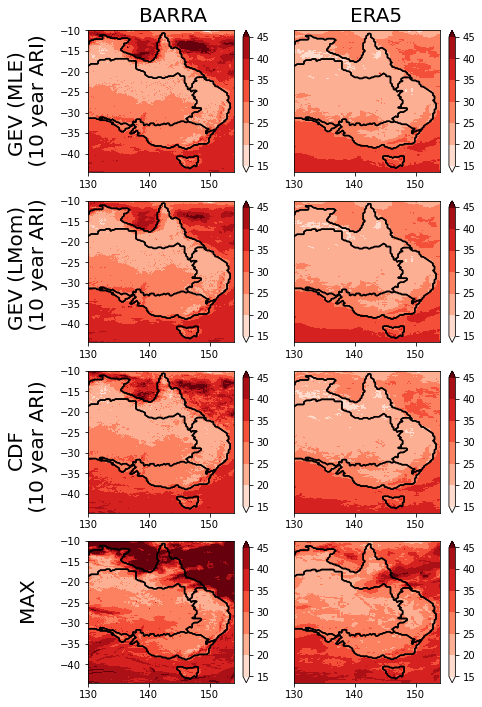

In [56]:
#PLOTTING - East Aus.

era5_range = [15,45]
barra_range = [15,45]
cmap = plt.get_cmap("Reds")
levels = 7

fig=plt.figure(figsize=([7,12]))

plt.subplot2grid((4,4), (0,0), rowspan=1, colspan=2)
xr.DataArray(data=barra_ari, coords=(barra_gev.lat, barra_gev.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154])

plt.subplot2grid((4,4), (1,0), rowspan=1, colspan=2)
#xr.DataArray(data=np.where(barra_gev.lmom_fail==0, barra_lmom_ari, np.nan), coords=(barra_gev.lat, barra_gev.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
xr.DataArray(data=barra_lmom_ari, coords=(barra_gev.lat, barra_gev.lon)).plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154])

plt.subplot2grid((4,4), (2,0), rowspan=1, colspan=2)
barra_cdf[cdf_ari].plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154])

plt.subplot2grid((4,4), (0,2), rowspan=1, colspan=2)
xr.DataArray(data=era5_ari, coords=(era5_gev.lat, era5_gev.lon)).plot(vmin=era5_range[0], vmax=era5_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154]); plt.yticks(ticks=[0])

plt.subplot2grid((4,4), (1,2), rowspan=1, colspan=2)
xr.DataArray(data=np.where(era5_gev.lmom_fail==0, era5_lmom_ari, np.nan), coords=(era5_gev.lat, era5_gev.lon)).plot(vmin=era5_range[0], vmax=era5_range[1], levels=levels, cmap=cmap, extend="both")
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154]); plt.yticks(ticks=[0])

plt.subplot2grid((4,4), (2,2), rowspan=1, colspan=2)
era5_cdf[cdf_ari].plot(vmin=era5_range[0], vmax=era5_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154]);plt.yticks(ticks=[0])

plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=2)
barra_max["max"].plot(vmin=barra_range[0], vmax=barra_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154])

plt.subplot2grid((4,4), (3,2), rowspan=1, colspan=2)
era5_max["max"].plot(vmin=era5_range[0], vmax=era5_range[1], levels=levels, cmap=cmap, extend="both", add_labels=False)
plot_borders(nrm_da)
plt.gca().set_ylabel(""); plt.gca().set_xlabel(""); plt.xlim([130, 154]); plt.yticks(ticks=[0])

fig.text(0.01, 0.72, "GEV (MLE)\n (10 year ARI)", rotation=90, size=20, ha="center")
fig.text(0.01, 0.53, "GEV (LMom)\n (10 year ARI)", rotation=90, size=20, ha="center")
fig.text(0.01, 0.32, "CDF\n (10 year ARI)", rotation=90, size=20, ha="center")
fig.text(0.01, 0.2, "MAX", rotation=90, size=20, ha="center")
fig.text(0.23, 0.89, "BARRA", size=20)
fig.text(0.65, 0.89, "ERA5", size=20)

plt.subplots_adjust(wspace=0.3, left=0.13)
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/ari/hist_ari10_barrra_era5_EASTAUS.png",bbox_inches="tight")

In [4]:
barra_sy_lmom_ari = compute_lmom_gev(barra_sy_gev, ari)
barra_sy_lmom_nrm, T = compute_lmom_gev_nrm(barra_sy_gev)

100%|██████████| 742/742 [01:21<00:00,  9.14it/s]


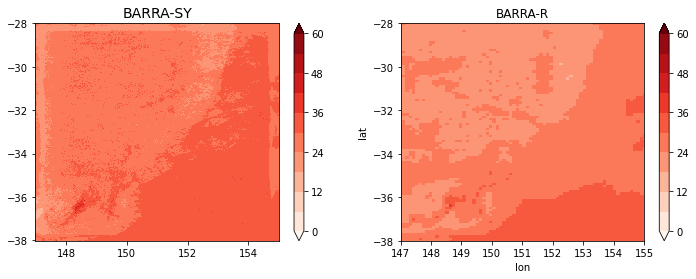

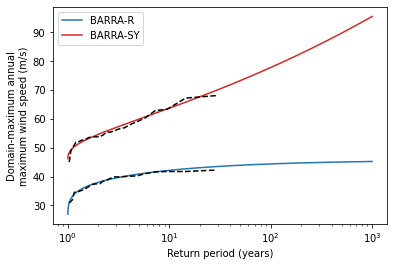

In [26]:
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
da = xr.DataArray(data=barra_sy_lmom_ari, coords=(barra_sy_gev.lat, barra_sy_gev.lon))
da.plot(vmin=0, vmax=60, levels=11, cmap=plt.get_cmap("Reds"), extend="both")
plt.gca().set_ylabel(""); plt.gca().set_xlabel("")
plt.title("BARRA-SY", size=14)

plt.subplot(1,2,2)
xr.DataArray(data=np.where(barra_gev.lmom_fail==0, barra_lmom_ari, np.nan), coords=(barra_gev.lat, barra_gev.lon)).\
        plot(vmin=0, vmax=60, levels=11, cmap=plt.get_cmap("Reds"), extend="both", xlim=[147, 155], ylim=[-38,-28])
plt.title("BARRA-R")

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/ari/barra_comapre_map.png", bbox_inches="tight")

plt.figure()
i=2
plt.plot(T, barra_ari_lmom_nrm[i], color="tab:blue", label="BARRA-R")
plt.plot(barra_cdf_nrm[i]["T"], barra_cdf_nrm[i]["wind_speed"], color="k", linestyle="--")
plt.plot(T, barra_sy_lmom_nrm[i], color="tab:red", label="BARRA-SY")
plt.plot(barra_sy_cdf_nrm[i]["T"], barra_sy_cdf_nrm[i]["wind_speed"], color="k", linestyle="--")
plt.xscale("log")
plt.xticks(ticks=[1,10,100,1000])
plt.legend()
plt.xlabel("Return period (years)"); plt.ylabel("Domain-maximum annual\nmaximum wind speed (m/s)")
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/ari/barra_comapre.png", bbox_inches="tight")


In [16]:
annmaxstr="_annmax";path = "/g/data/eg3/ab4502/gev/"; y1=1990; y2=2018

In [61]:
barra_sy_cdf_nrm[i]["T"]

0      1.000000
1      1.035714
2      1.074074
3      1.115385
4      1.160000
5      1.208333
6      1.260870
7      1.318182
8      1.380952
9      1.450000
10     1.526316
11     1.611111
12     1.705882
13     1.812500
14     1.933333
15     2.071429
16     2.230769
17     2.416667
18     2.636364
19     2.900000
20     3.222222
21     3.625000
22     4.142857
23     4.833333
24     5.800000
25     7.250000
26     9.666667
27    14.500000
28    29.000000
29          inf
Name: T, dtype: float64